In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
from sklearn.preprocessing import StandardScaler

In [ ]:
# Use GPU if available, else fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
# Load Data
from google.colab import drive
import sqlite3
import pandas as pd

drive.mount('/content/drive')
conn = sqlite3.connect('/content/drive/My Drive/Colab Notebooks/C3S.db')  # Replace with your database path
cursor = conn.cursor()
master_df = pd.read_sql_query("SELECT * FROM master", conn)
mqn_df = pd.read_sql_query("SELECT * FROM mqns", conn)

c3s_df = pd.merge(master_df, mqn_df, on='g_id', how='left')
conn.close()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
features = [
    "mz", "adduct",
    "c", "f", "cl", "br", "i", "s", "p", "an", "cn", "ao", "co",
    "hac", "hbam", "hba", "hbdm", "hbd", "neg", "pos", "asb", "adb",
    "atb", "csb", "cdb", "ctb", "rbc", "asv", "adv", "atv", "aqv",
    "cdv", "ctv", "cqv", "r3", "r4", "r5", "r6", "r7", "r8", "r9",
    "rg10", "afr", "bfr"
    ]

target = "ccs"

c3s_df_encoded = c3s_df[features + [target]]

# Adducts to One Hot Encode
adduct_groups = {
    "[M+H]+", "[M+Na]+", "[M-H]-", "[M+NH4]+", "[M+K]+",
    "[M+H-H2O]+", "[M+HCOO]-", "[M+CH3COO]-", "[M+Na-2H]-"
}

# One-hot encode the grouped adducts
c3s_df_encoded["adduct_grouped"] = c3s_df_encoded["adduct"].apply(lambda x: x if x in adduct_groups else "Other")
c3s_df_encoded = pd.get_dummies(c3s_df_encoded, columns=["adduct_grouped"])

# Rename 'adduct_grouped_Other' to 'adduct_Other' for clarity
c3s_df_encoded.rename(columns={"adduct_grouped_Other": "adduct_Other"}, inplace=True)
c3s_df_encoded.drop(columns=["adduct"], inplace=True)

print(f"Number of entries in C3S Total: {c3s_df_encoded.shape}")

c3s_df_encoded = c3s_df_encoded.dropna()

print(f"Number of entries in C3S excluding nan rows: {c3s_df_encoded.shape}")
# print(c3s_df_encoded.head())

Number of entries in C3S Total: (17679, 54)
Number of entries in C3S excluding nan rows: (15187, 54)


<ipython-input-4-4ef973059af8>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c3s_df_encoded["adduct_grouped"] = c3s_df_encoded["adduct"].apply(lambda x: x if x in adduct_groups else "Other")


In [ ]:
# Ensure all object columns are converted (shouldn't be needed after get_dummies)
object_columns = c3s_df_encoded.select_dtypes(include=['object']).columns
if len(object_columns) > 0:
    print("Warning: Object columns detected!", object_columns)

# Ensure all columns are numeric
c3s_df_encoded = c3s_df_encoded.astype(np.float32)

# #CONVERTING DATAFRAME TO TENSOR
X_numpy = c3s_df_encoded.drop(columns=[target]).to_numpy(dtype=np.float32)
y_numpy = c3s_df_encoded[target].to_numpy(dtype=np.float32).reshape(-1, 1) #(N , 1)

# #NORMALIZE DATA FIRST
# scaler = StandardScaler()
# X_numpy = scaler.fit_transform(X_numpy)
# # y_numpy = scaler.fit_transform(y_numpy)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_numpy, dtype=torch.float32)
y_tensor = torch.tensor(y_numpy, dtype=torch.float32)

# Debug prints
print(f"X shape: {X_tensor.shape}")
print(f"y shape: {y_tensor.shape}")
print("First 2 x values tensor:", X_tensor[:2])
print('\n')
print("First 2 y values tensor:", y_tensor[:2])

X shape: torch.Size([15187, 53])
y shape: torch.Size([15187, 1])
First 2 x values tensor: tensor([[137.0715,   7.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   1.0000,   1.0000,   1.0000,   0.0000,  10.0000,   3.0000,
           1.0000,   0.0000,   3.0000,   3.0000,   0.0000,   1.0000,   4.0000,
           3.0000,   2.0000,   1.0000,   0.0000,   1.0000,   3.0000,   0.0000,
           1.0000,   0.0000,   4.0000,   2.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   1.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   1.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000],
        [298.1151,  11.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   1.0000,   4.0000,   4.0000,   1.0000,  21.0000,   7.0000,
           1.0000,   0.0000,  10.0000,   5.0000,   0.0000,   2.0000,  15.0000,
          10.0000,   6.0000,   5.0000,   0.0000,   1.0000,   6.0000,  

In [ ]:
#TRUE IF WANT TO USE SUBSET OF DATA
#FALSE for full training data

SAMPLE_DATA = True

In [ ]:
#Compiling DATASET into DATALOADERS

dataset = TensorDataset(X_tensor, y_tensor) # Combines Features and Target variable together

total = len(dataset)
train_size = int(0.8 * total)
test_size = int(0.1 * total)
validation_size = total - train_size - test_size  # Ensures all samples are used

BATCH_SIZE = 64

# Split dataset into train, validation, and test sets
train_dataset, test_dataset, validation_dataset = random_split(dataset, [train_size, test_size, validation_size])

if SAMPLE_DATA:
    sample_train_size = min(BATCH_SIZE * 10, len(train_dataset))
    sample_val_size = min(BATCH_SIZE * 10, len(validation_dataset))
    sample_test_size = min(BATCH_SIZE * 10, len(test_dataset))

    #grabs subsets from the full dataset
    trainset, _ = random_split(train_dataset, [sample_train_size, len(train_dataset) - sample_train_size])
    valset, _ = random_split(validation_dataset, [sample_val_size, len(validation_dataset) - sample_val_size])
    testset, _ = random_split(test_dataset, [sample_test_size, len(test_dataset) - sample_test_size])
else:
    trainset, valset, testset = train_dataset, validation_dataset, test_dataset

# Create DataLoaders -> for batch sampling
train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
validation_loader = DataLoader(valset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Get number of features (D)
D = X_tensor.shape[1]
print(f"Number of features: {D}")
print(f"Number of total Entries: {total}")
print(f"Number of train Entries: {len(trainset)}")
print(f"Number of validation Entries: {len(valset)}")
print(f"Number of test Entries: {len(testset)}")


Number of features: 53
Number of total Entries: 15187
Number of train Entries: 640
Number of validation Entries: 640
Number of test Entries: 640


In [ ]:
for batch_idx, (data, target) in enumerate(train_loader):
        print(f"Batch {batch_idx}: Data shape = {data.shape}, Target shape = {target.shape}")
        break  # Print only the first batch's shape

Batch 0: Data shape = torch.Size([64, 53]), Target shape = torch.Size([64, 1])


#PLS-RA

In [ ]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler

# Standardize the data (important for PLS)
scaler_X = StandardScaler()

#Normalized Here
X_scaled = scaler_X.fit_transform(X_numpy)

print(X_scaled.shape[1]) #number of features

print(f"X_scaled shape: {X_scaled[:1]}")
print(f"y normal shape: {y_numpy[:1]}")

53
X_scaled shape: [[-1.3506614  -1.0639896  -0.11190958 -0.2185339  -0.08218891 -0.05278343
  -0.29173702 -0.55854267  0.22672957  0.40823168 -1.1443443  -0.3873107
  -1.2024757  -1.0147344  -0.53936183 -0.08141389 -0.44646943  0.25406143
   0.         -0.89935476 -0.99592525 -0.8365337  -0.21769497 -0.48216662
  -0.33964655  2.678653   -0.94867307 -0.8069513  -0.4966569  -0.49473977
   0.02937161 -0.41184264 -0.33279762 -0.14496993 -0.08535525 -0.5206205
  -0.15550756 -0.1195198  -0.03539261 -0.03631325 -0.04596629 -0.4603966
  -0.31848454  4.191183   -0.1293714  -0.2078617  -0.12151874 -0.74985856
  -0.22080204 -0.28121522 -0.10187517 -0.52280915 -0.4511127 ]]
y normal shape: [[126.4]]


In [ ]:
num_components = min(X_scaled.shape[1], 10)  #input features , latent dimensions

# Fit PLS Regression
pls = PLSRegression(n_components=num_components)
pls.fit(X_scaled, y_numpy)

# Get transformed features
X_pls = pls.transform(X_scaled)

ValueError: Input X contains NaN.
PLSRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
# Print explained variance
print("Explained variance by PLS components:", pls.explained_variance_ratio_ if hasattr(pls, "explained_variance_ratio_") else "N/A")

# Convert back to PyTorch tensor if needed
X_pls_tensor = torch.tensor(X_pls, dtype=torch.float32, device=device)

#Autoencoder


In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, latent_dim=16):
        """
        input_dim: dimensionality of input data (D)
        latent_dim: dimensionality of the bottleneck layer
        """
        super(AutoEncoder, self).__init__()

        # Encoder: maps input to latent vector -> lower dimension
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),

            nn.Linear(64, 32),
            nn.ReLU(),

            nn.Linear(32, latent_dim)
        )

        # Decoder: reconstructs input from latent vector
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z = self.encode(x)
        reconstructed = self.decode(z)
        return reconstructed

In [ ]:
# Initialize the autoencoder
latent_dim = 16  #final latent dimensions
autoencoder_model = AutoEncoder(input_dim=D, latent_dim=latent_dim).to(device)

# Autoencoder uses L1 regularization for reconstruction -> for feature selection
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder_model.parameters(), lr=1e-4) #CAN GRID SEARCH HERE


In [ ]:
# Training Loop
torch.autograd.set_detect_anomaly(True)
num_epochs = 20

# Training Loop
num_epochs = 20
for epoch in range(num_epochs):
    autoencoder_model.train()
    total_loss = 0.0

    for batch in train_loader:
        x_batch = batch[0].to(device)

        # Forward pass
        reconstructed = autoencoder_model(x_batch)
        loss = criterion(reconstructed, x_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

print("Training complete!")

Epoch [5/20], Loss: 6089.5253
Epoch [10/20], Loss: 5996.3058
Epoch [15/20], Loss: 5671.2565
Epoch [20/20], Loss: 4681.9428
Training complete!


In [ ]:
# Extract Latent Embeddings

autoencoder_model.eval()

with torch.no_grad():
    # Encode the entire dataset to get latent vectors
    X_latent = []
    for batch in train_loader:
        x_batch = batch[0].to(device)
        z = autoencoder_model.encode(x_batch)
        X_latent.append(z.cpu().numpy())

    # Concatenate all latent vectors into one array
    X_latent = np.concatenate(X_latent, axis=0)

print("Shape of latent representations:", X_latent.shape) #latent representation (also called the bottleneck layer)

df_latent = pd.DataFrame(X_latent)
df_latent.head()

Shape of latent representations: (640, 16)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-28.167721,-16.869663,-38.625114,-21.519382,-5.880237,28.165070,14.953264,16.716862,-26.482983,-9.459807,11.729166,-18.824837,9.646103,-18.620653,25.499838,16.237953
1,-92.693825,-57.009338,-128.188187,-70.363075,-18.988579,90.995491,49.768963,55.630394,-88.894478,-31.310032,39.033157,-60.450634,32.145241,-60.647045,86.215851,53.122211
2,-100.115257,-61.739113,-138.538712,-75.732582,-20.471647,98.065872,53.579060,60.022728,-96.241341,-33.682575,42.123272,-64.973534,34.967762,-65.407639,93.141853,57.005951
3,-38.944183,-23.582579,-53.489704,-29.826578,-8.119054,38.622990,20.991383,23.274677,-36.732811,-13.264871,16.300257,-25.975601,13.213985,-25.587406,35.676048,22.650547
4,-88.951103,-55.436054,-123.154358,-67.322128,-17.935978,86.475983,47.345108,53.423351,-84.596031,-30.648981,37.861588,-56.935627,30.695606,-57.348610,81.589790,49.949200


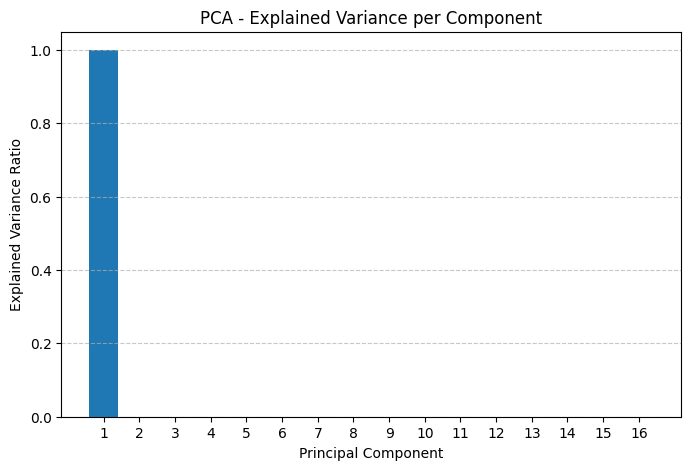

[9.9978513e-01 1.5654719e-04 4.3187869e-05 7.2391031e-06 4.7776571e-06
 1.4103738e-06 9.6133977e-07 3.7993377e-07 2.3539997e-07 1.5983973e-07
 7.2482848e-08 3.4738036e-08 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00]


In [ ]:
#Find out what are the potential features taken in the final latent dimensions

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Perform PCA to investigate which features are the most represented
pca = PCA(n_components=16)
pca.fit(df_latent)

# Get explained variance
explained_variance = pca.explained_variance_ratio_

# Create a DataFrame for visualization
pca_df = pd.DataFrame({'Component': range(1, 17), 'Explained Variance': explained_variance})

# Plot the explained variance
plt.figure(figsize=(8, 5))
plt.bar(range(1, 17), explained_variance, tick_label=np.arange(1, 17))
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("PCA - Explained Variance per Component")
plt.xticks(np.arange(1, 17))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print(explained_variance)

#KMeans

Cluster-Specific Regression:

Next, you would take X_latent and run k-means to find clusters.
Then, for each cluster, you can train a separate MLP regressor (using your original input features or the latent vectors) to predict CCS.


In [ ]:
!pip install kmeans-pytorch

In [ ]:
import torch
from kmeans_pytorch import kmeans

In [ ]:
X_latent_tensor = torch.from_numpy(X_latent).to(device)

num_clusters = 4

# Run K-Means clustering on the latent representation
cluster_ids, cluster_centers = kmeans(
    X_latent_tensor, num_clusters, distance='euclidean', device=device
)

running k-means on cuda..


[running kmeans]: 7it [00:00, 13.41it/s, center_shift=0.000000, iteration=7, tol=0.000100]


In [ ]:
print(X_latent.shape)
print(X_latent_tensor.shape)

(640, 16)
torch.Size([640, 16])


Cluster IDs for the first 10 samples: tensor([1, 2, 2, 3, 2, 3, 3, 3, 1, 1])
Cluster Centers:
 tensor([[ -64.0989,  -38.9265,  -88.5377,  -49.1227,  -13.2768,   63.5620,
           34.5520,   38.4427,  -61.0193,  -21.7447,   26.9104,  -42.5918,
           22.0359,  -42.2664,   59.3475,   37.2656],
        [ -24.3637,  -14.6877,  -33.3923,  -18.6025,   -5.0602,   24.1951,
           13.0206,   14.4971,  -23.0385,   -8.1160,   10.0980,  -16.2816,
            8.3238,  -16.0903,   22.3791,   14.2200],
        [ -99.4254,  -61.1740, -137.5991,  -75.5860,  -20.3765,   97.6174,
           53.3350,   59.7029,  -95.0983,  -33.7718,   41.9147,  -64.8564,
           34.4270,  -64.9386,   92.1785,   56.8889],
        [ -40.8716,  -24.6473,  -56.2497,  -31.2875,   -8.5254,   40.6738,
           21.9541,   24.3791,  -38.7938,  -13.7463,   16.9940,  -27.3381,
           14.0763,  -27.0389,   37.6652,   23.8108]])
Cluster ID shape: torch.Size([640])
Cluster Center shape: torch.Size([4, 16])
Unique clu

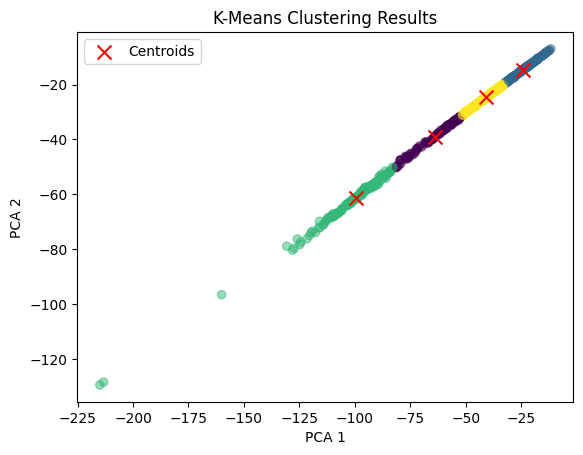

In [ ]:
# Print the results
print("Cluster IDs for the first 10 samples:", cluster_ids[:10])
print("Cluster Centers:\n", cluster_centers)

# Ensure cluster_ids and cluster_centers are well-formed
print("Cluster ID shape:", cluster_ids.shape)  # Should be (num_samples,)
print("Cluster Center shape:", cluster_centers.shape)  # Should be (num_clusters, num_features)

# Check if all cluster IDs are within the expected range
print("Unique cluster IDs:", torch.unique(cluster_ids))


cluster_ids_np = cluster_ids.cpu().numpy()
plt.scatter(X_latent[:, 0], X_latent[:, 1], c=cluster_ids_np, cmap='viridis', alpha=0.5)
plt.scatter(cluster_centers[:, 0].cpu().numpy(), cluster_centers[:, 1].cpu().numpy(),
            c='red', marker='x', s=100, label="Centroids")
plt.title("K-Means Clustering Results")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.show()

#Training Functions

In [ ]:
# Example training function that returns train and validation loss histories
def train(model, train_loader, val_loader, num_epochs, learning_rate, compute_accs=False):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()  # Using MSE for regression
    train_history = []
    val_history = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        avg_train_loss = total_train_loss / len(train_loader)
        train_history.append(avg_train_loss)

        # Validation phase
        model.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                outputs = model(X_val)
                loss = criterion(outputs, y_val)
                total_val_loss += loss.item()
        avg_val_loss = total_val_loss / len(val_loader)
        val_history.append(avg_val_loss)

        mre_train = total_train_loss / len(train_loader.dataset)
        mre_val = total_val_loss / len(val_loader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        print(f"Epoch {epoch+1}/{num_epochs}, MRE Train: {mre_train:.4f}, MRE Val: {mre_val:.4f}")
    return train_history, val_history, model

# Example plot function to visualize the loss histories
def plot_history(histories):
    for h in histories:
        epochs = range(1, len(h['train_loss']) + 1)
        plt.plot(epochs, h['train_loss'], label=f"{h['name']} Train Loss")
        plt.plot(epochs, h['val_loss'], label=f"{h['name']} Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

#MLP Regressor

In [ ]:
class MLPRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim=8, output_dim=1):
        super(MLPRegressor, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()

        # self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        # self.relu = nn.ReLU()

        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)

        # x = self.fc2(x)
        # x = self.relu(x)

        x = self.fc3(x)

        return x


In [ ]:
print(X_latent_tensor[:1])
print(X_latent_tensor.shape[0]) #number of entries
print(X_latent_tensor.shape[1]) # input Dimension

print(train_loader)

tensor([[-28.1677, -16.8697, -38.6251, -21.5194,  -5.8802,  28.1651,  14.9533,
          16.7169, -26.4830,  -9.4598,  11.7292, -18.8248,   9.6461, -18.6207,
          25.4998,  16.2380]], device='cuda:0')
640
16


Epoch 1/30, Train Loss: 51516.5020, Val Loss: 47255.4227
Epoch 1/30, MRE Train: 804.9453, MRE Val: 738.3660
Epoch 2/30, Train Loss: 46390.2156, Val Loss: 42840.5590
Epoch 2/30, MRE Train: 724.8471, MRE Val: 669.3837
Epoch 3/30, Train Loss: 42141.5195, Val Loss: 39132.8496
Epoch 3/30, MRE Train: 658.4612, MRE Val: 611.4508
Epoch 4/30, Train Loss: 38412.0738, Val Loss: 35948.9137
Epoch 4/30, MRE Train: 600.1887, MRE Val: 561.7018
Epoch 5/30, Train Loss: 35618.6844, Val Loss: 33743.0205
Epoch 5/30, MRE Train: 556.5419, MRE Val: 527.2347
Epoch 6/30, Train Loss: 33470.0500, Val Loss: 31748.3873
Epoch 6/30, MRE Train: 522.9695, MRE Val: 496.0686
Epoch 7/30, Train Loss: 31384.6969, Val Loss: 29748.1939
Epoch 7/30, MRE Train: 490.3859, MRE Val: 464.8155
Epoch 8/30, Train Loss: 29264.8289, Val Loss: 27714.4359
Epoch 8/30, MRE Train: 457.2630, MRE Val: 433.0381
Epoch 9/30, Train Loss: 27124.8256, Val Loss: 25644.9318
Epoch 9/30, MRE Train: 423.8254, MRE Val: 400.7021
Epoch 10/30, Train Loss: 249

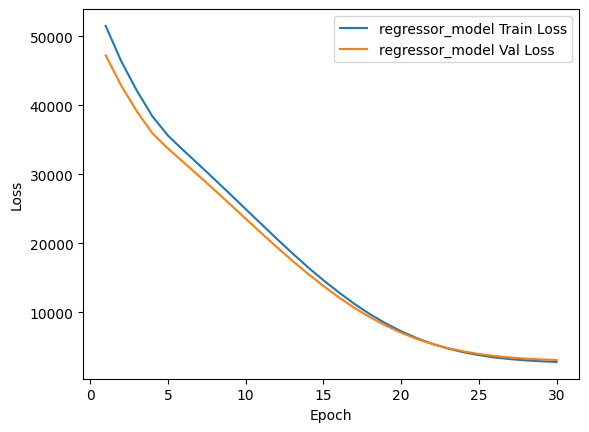

In [ ]:
# #Running a global model

# regressor_model = MLPRegressor(input_dim=X_latent_tensor.shape[1]).to(device)

# # Train the model using the train function
# train_history_A, val_history_A, best_model = train(regressor_model, train_loader, validation_loader,
#     num_epochs=30, learning_rate=1e-3, compute_accs=True)

# histories_A = [{
#     'name': 'regressor_model',
#     'train_loss': train_history_A,
#     'val_loss': val_history_A
# }]

# # Plot the loss histories
# plot_history(histories_A)

#Running a global model

# Change input_dim to match the original feature dimension
regressor_model = MLPRegressor(input_dim=X_tensor.shape[1]).to(device)

# Train the model using the train function
train_history_A, val_history_A, best_model = train(regressor_model, train_loader, validation_loader,
    num_epochs=30, learning_rate=1e-3, compute_accs=True)

histories_A = [{
    'name': 'regressor_model',
    'train_loss': train_history_A,
    'val_loss': val_history_A
}]

# Plot the loss histories
plot_history(histories_A)

Cluster 0: 90 samples
Epoch 1/30, Train Loss: 27042.6719, Val Loss: 27727.5020
Epoch 1/30, MRE Train: 600.9483, MRE Val: 616.1667
Epoch 2/30, Train Loss: 27954.5684, Val Loss: 26729.1377
Epoch 2/30, MRE Train: 621.2126, MRE Val: 593.9808
Epoch 3/30, Train Loss: 27230.1426, Val Loss: 26053.9453
Epoch 3/30, MRE Train: 605.1143, MRE Val: 578.9766
Epoch 4/30, Train Loss: 26354.2686, Val Loss: 25555.0146
Epoch 4/30, MRE Train: 585.6504, MRE Val: 567.8892
Epoch 5/30, Train Loss: 26284.1377, Val Loss: 26082.4258
Epoch 5/30, MRE Train: 584.0919, MRE Val: 579.6095
Epoch 6/30, Train Loss: 25912.9170, Val Loss: 27632.6709
Epoch 6/30, MRE Train: 575.8426, MRE Val: 614.0594
Epoch 7/30, Train Loss: 25820.5918, Val Loss: 26041.0938
Epoch 7/30, MRE Train: 573.7909, MRE Val: 578.6910
Epoch 8/30, Train Loss: 24350.1650, Val Loss: 25345.9160
Epoch 8/30, MRE Train: 541.1148, MRE Val: 563.2426
Epoch 9/30, Train Loss: 25540.1523, Val Loss: 24627.4688
Epoch 9/30, MRE Train: 567.5589, MRE Val: 547.2771
Epoch 

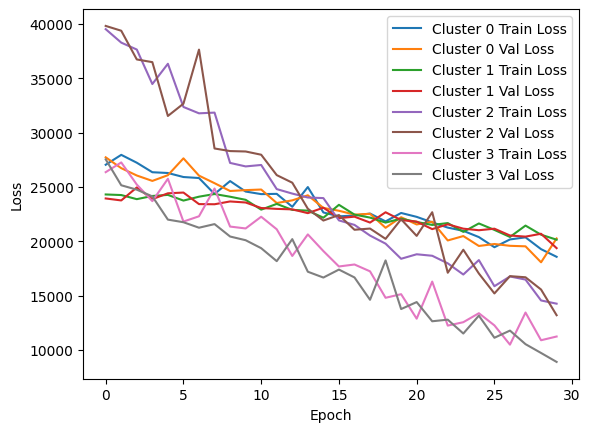

In [ ]:
# Assuming cluster_ids is a tensor with cluster labels for each sample
cluster_models = {}
num_clusters = 4  # or the number you used in KMeans

for cluster in range(num_clusters):
    # Get the indices for the current cluster
    indices = (cluster_ids == cluster).nonzero(as_tuple=True)[0]
    X_cluster = X_latent_tensor[indices]
    y_cluster = y_tensor[indices]

    print(f"Cluster {cluster}: {len(indices)} samples")

    # Create a dataset and DataLoader for this cluster
    dataset_cluster = TensorDataset(X_cluster, y_cluster)
    loader_cluster = DataLoader(dataset_cluster, batch_size=64, shuffle=True)

    # Initialize a new MLP regressor for this cluster
    regressor_cluster = MLPRegressor(input_dim=X_cluster.shape[1]).to(device)

    # Optional: Create a validation split for this cluster if needed
    # For simplicity, here we use the same loader for both train and validation
    train_hist, val_hist, best_model = train(regressor_cluster, loader_cluster, loader_cluster,
                                             num_epochs=30, learning_rate=1e-3, compute_accs=True)

    cluster_models[cluster] = {
        "model": regressor_cluster,
        "train_loss": train_hist,
        "val_loss": val_hist
    }

# Optionally, plot histories for each cluster model:
for cluster, comp in cluster_models.items():
    plt.plot(comp["train_loss"], label=f"Cluster {cluster} Train Loss")
    plt.plot(comp["val_loss"], label=f"Cluster {cluster} Val Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


#Graph Neural Network

In [ ]:
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data
import torch.nn.functional as F

ModuleNotFoundError: No module named 'torch_geometric'

In [ ]:
#Amogh's GNN
class GNN(torch.nn.Module):
    def __init__(self, hidden_channels1, hidden_channels2, hidden_channels3, num_features):
        """
          Behavior: Initialize the Graph Convolutional Neural Network layers with distinct number of neurons.
          Since our class is inheiriting a Pytorch neural network module, we first need to initialize the base class torch.nn.Module to be able to
          gain access to Pytorch methods that will help us use this class to manage and build a neural network.

          Then we initialize our first layer which has an input layer of 17 (because each atom has 17 descriptors), then a middle layer
          with 256 nuerons, then second middle layer goes from 256 -> 128, then last middle layer goes from 128 -> 64 nuerons.
          Then we have a fully connected linear layer to process molecular features (mz, adduct) and we send those to a
          layer with 64 neurons. Lastly, we define a output layer which will a single scalar value (ccs), and since we concatenate the neurons
          from the atomic features (GCN) and graph-level features (Linear), we must multiply by 2.

          Exceptions: None

          Returns: None

          Parameters:
          - hiddden_channels1: the number of neurons in the 1st hidden layer
          - hiddle_channels2: the number of neurons in the 2nd hidden layer
          - hiddle_channels3: the number of neurons in the 3rd hidden layer
        """
        super(GNN, self).__init__()
        self.input = GCNConv(num_features, hidden_channels1)  # Use num_features
        self.hidden1 = GCNConv(hidden_channels1, hidden_channels2)
        self.hidden2 = GCNConv(hidden_channels2, hidden_channels3)

        self.output = Linear(hidden_channels3, 1)
        self.dropout_rates = [0.5, 0.3, 0.1]

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = self.input(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout_rates[0], training=self.training)

        x = self.hidden1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout_rates[1], training=self.training)

        x = self.hidden2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout_rates[2], training=self.training)

        x = global_mean_pool(x, batch)

        return self.output(x)


In [ ]:
# Assuming X_tensor and y_tensor are your features and targets
# and you have edge_index (connectivity information)
# Example edge_index (replace with your actual data):
edge_index = torch.randint(0, X_tensor.shape[0], (2, 100))

# Initialize and train the GNN model
gnn_model = GNN(hidden_channels1=64, hidden_channels2=32, hidden_channels3=16, naum_features=X_tensor.shape[1]).to(device)

# Train the model using the train function
train_history_A, val_history_A, best_model = train(gnn_model, train_loader, validation_loader,
    num_epochs=30, learning_rate=1e-3, compute_accs=True)

histories_A = [{
    'name': 'gnn_model',
    'train_loss': train_history_A,
    'val_loss': val_history_A
}]

plot_history(histories_A)

TypeError: GNN.__init__() got an unexpected keyword argument 'naum_features'